In [460]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares
import pandas as pd
from scipy import constants

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [461]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IR_KIDS_CHAR\2o raff\RES_DATA'

In [462]:
data = pd.read_csv(parent+r'\RES0.txt', sep='\t')

In [484]:
def resonance_model(x, pars):
    return 1-pars[1]*np.exp(1j*pars[2])/(1-1j*((2*x*pars[0])-pars[3]))

polyorder = 2

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.abs(res)+pol

def phase(x,*pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.unwrap(np.angle(1j*res.imag+res.real+pol))

In [471]:
F = data['F']
I = data['I']
Q = data['Q']

In [472]:
def compute_Qi_err(Q, R, phi, sQ, sR, sphi):
    a = ((1-R*np.cos(phi))/Q**2)**2*sQ**2
    b = ((1-np.cos(phi))/Q)**2*sR**2
    c = ((1+R*np.sin(phi))*R/Q)**2*sphi**2
    return np.sqrt(a+b+c)

def compute_Qc_err(Q, R, phi, sQ, sR, sphi):
    a = 1/(R*np.cos(phi))**2*sQ**2
    b = (Q/(R**2*np.cos(phi))**2)**2*sR**2
    c = (Q*np.sin(phi)/(R*np.cos(phi)**2))**2*sphi**2
    return np.sqrt(a+b+c)

In [473]:
F = np.array(F)
C = np.array(Q)+1j*np.array(I)
A = np.abs(C)
P = np.unwrap(np.angle(C))

Text(0, 0.5, '$\\phi$ [rad]')

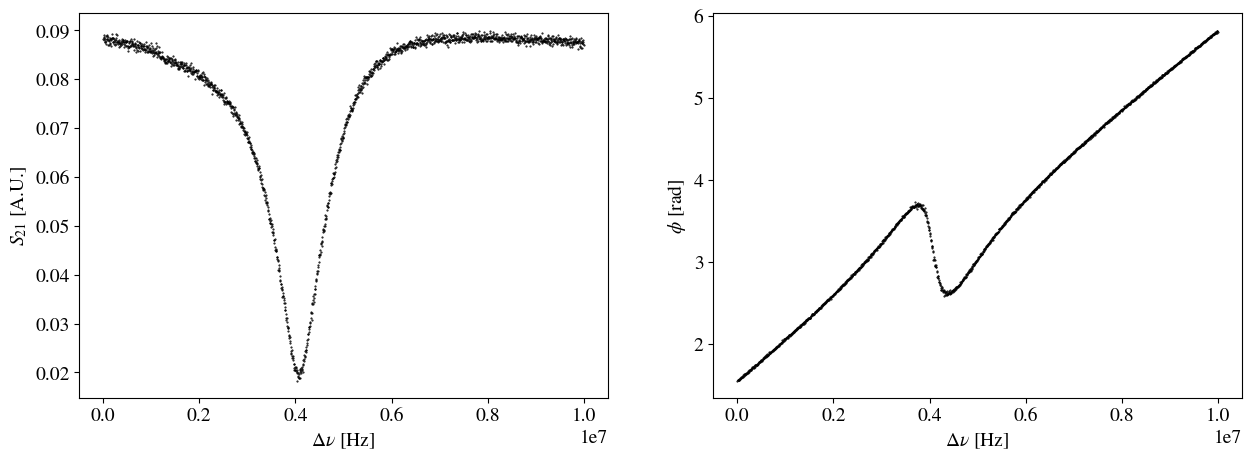

In [474]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')

In [475]:
A /= max(A)
F = (F - F[np.argmin(A)])/F[np.argmin(A)]
a = np.polyfit(F,P,1)
P = P - np.polyval(a,F)
#A = A[np.argmin(A)-200:np.argmin(A)+200]
#F = F[np.argmin(A)-200:np.argmin(A)+200]
#P = P[np.argmin(A)-200:np.argmin(A)+200]
len_fit = int(np.floor(len(A)/10))
pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))   

In [476]:
pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

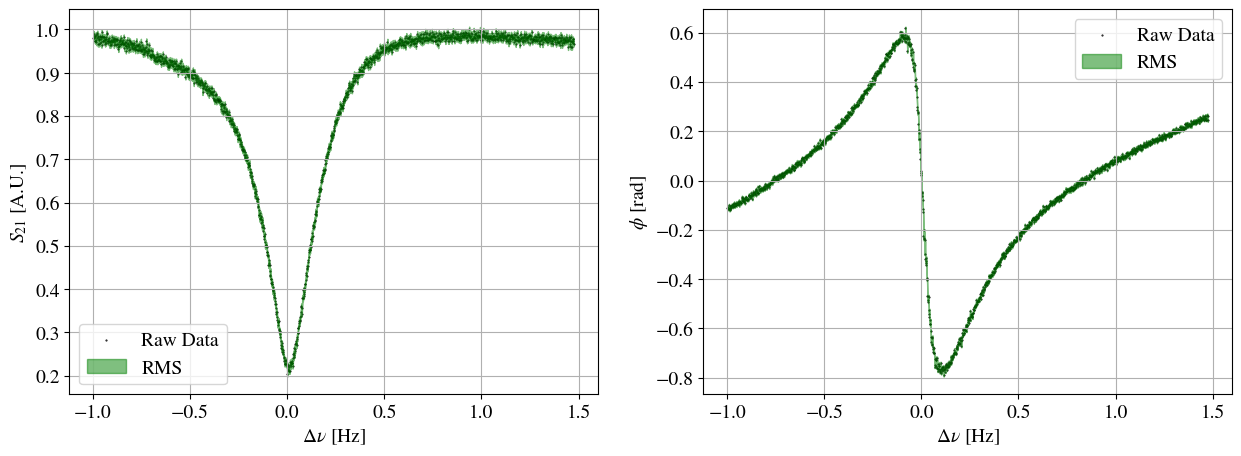

In [477]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [478]:
p0 = [1e-13,1e-9,0,50,1,5,0]

In [485]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
m.migrad(ncall=10000, iterate=1000)

lsqp = LeastSquares(F,P,P_rms*np.ones(len(P)),phase)
mp = minuit.Minuit(lsqp, *p0)
mp.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.803e+05 (χ²/ndof = 238.9)│              Nfcn = 852              │
│ EDM = 0.000182 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   5.53    │   0.05    │            │            │         │         │       │
│ 1 │ x1   │  -2.039   │   0.019   │            │            │         │         │       │
│ 2 │ x2   │  -0.179   │   0.008   │            │            │         │         │       │
│ 3 │ x3   │   2.123   │   0.005   │            │            │         │         │       │
│ 4 │ x4   │   0.746   │   0.007   │            │            │         │         │       │
│ 5 │ x5   │  5.8024   │  0.0017   │            │            │         │         │       │
│ 6 │ x6   │  -0.5229  │  0.0022   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │   0.00267   -1.0e-3   0.38e-3 -0.009e-3   0.35e-3  -10.9e-6    -14e-6 │
│ x1 │   -1.0e-3  0.000374  -0.14e-3 -0.016e-3  -0.13e-3    8.6e-6     11e-6 │
│ x2 │   0.38e-3  -0.14e-3  5.63e-05        -0   0.05e-3   -0.2e-6     -0e-6 │
│ x3 │ -0.009e-3 -0.016e-3        -0  2.26e-05  0.001e-3   -3.9e-6     -5e-6 │
│ x4 │   0.35e-3  -0.13e-3   0.05e-3  0.001e-3  4.72e-05   -1.2e-6     -2e-6 │
│ x5 │  -10.9e-6    8.6e-6   -0.2e-6   -3.9e-6   -1.2e-6  2.92e-06    3.8e-6 │
│ x6 │    -14e-6     11e-6     -0e-6     -5e-6     -2e-6    3.8e-6  4.95e-06 │
└────┴───────────────────────────────────────────────────────────────────────┘

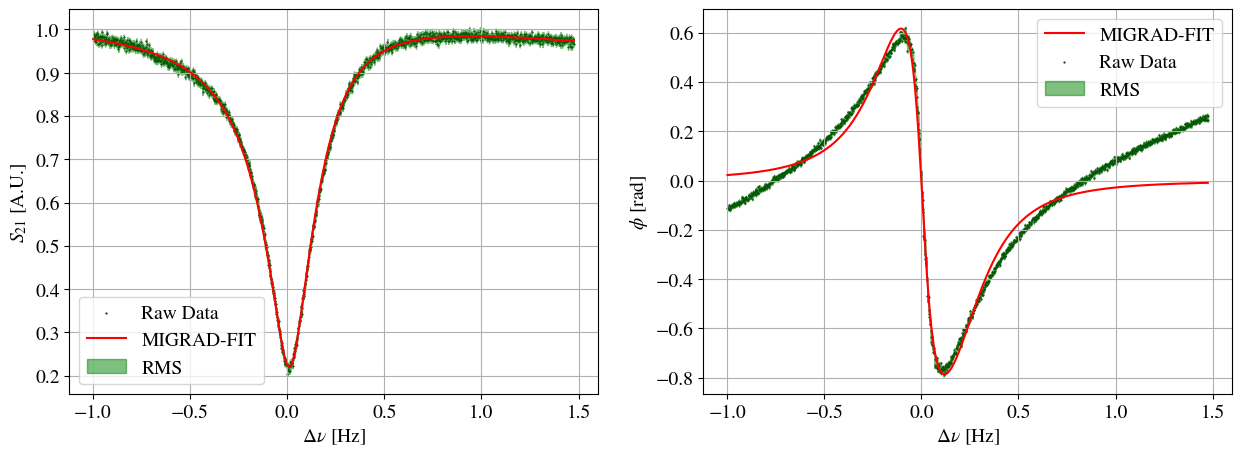

In [486]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs[1].plot(F, phase(F,*mp.values), color='red',label='MIGRAD-FIT')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [487]:
Q = m.values[polyorder+1]
R = m.values[polyorder+2]
phi = m.values[polyorder+3]
Qi = Q/(1-R*(np.cos(phi)))
Qc = Q/(R*(np.cos(phi)))

In [488]:
Qp = mp.values[polyorder+1]
Rp = mp.values[polyorder+2]
phip = mp.values[polyorder+3]
Qip = Qp/(1-Rp*(np.cos(phip)))
Qcp = Qp/(Rp*(np.cos(phip)))

In [489]:
print('Q(S21) = ', Q)
print('Q(phase) = ', Qp)
print('Q_i(S21) = ', Qi)
print('Q_i(phase) = ', Qip)

Q(S21) =  2.2239690701950643
Q(phase) =  2.1227956242580897
Q_i(S21) =  10.501808969500567
Q_i(phase) =  6.269459775553227
